In [19]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.models import Model
import numpy as np
from scipy.misc import imresize
from os import listdir, walk
from os.path import isfile, join
import os
import itertools
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
def getAllFilesInDirectory(directoryPath: str):
    return [(directoryPath + "/" + f) for f in listdir(directoryPath) if isfile(join(directoryPath, f)) and f[-4:] == '.jpg']

def predict(img_path : str, model: Model):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return model.predict(x)

def findDifference(f1, f2):
    return np.linalg.norm([a - b for a, b in zip(f1, f2)])
    #return np.linalg.norm(f1-f2)

def findDifferences(feature_vectors):
    similar: dict = {}
    keys = [k for k,v in feature_vectors.items()]
    min : dict = {}
    for k in keys:
        min[k] = 10000000
    possible_combinations=list(itertools.combinations(keys, 2))
    for k,v in possible_combinations:
        diff=findDifference(feature_vectors[k],feature_vectors[v])
        if(diff < min[k]):
            min[k] = diff
            similar[k] = v
            min[v] = diff
            similar[v] = k
    return similar 

def driver(IMAGE_DIR):
    feature_vectors: dict = {}
    model = ResNet50(weights='imagenet')
    for img_path in getAllFilesInDirectory(IMAGE_DIR):
        feature_vectors[img_path] = predict(img_path,model)[0].tolist()
    #results=findDifferences(feature_vectors)
    #for k,v in results.items():
       # print(k +" is most similar to: "+ v)    
    #print('Predicted:', decode_predictions(preds, top=3)[0])
    return feature_vectors


def predict_all(image_feature_vectors, custom_feature_vectors):
    similar = {}
    for k in custom_feature_vectors:
        #ans = 1 << 30
        diff = {}
        for v in image_feature_vectors:
            diff[v] =findDifference(custom_feature_vectors[k], image_feature_vectors[v])
            #if diff < ans:
                #similar[k] = v
        A = sorted(diff.items(), key = lambda x: x[1])[:3]
        similar[k] = [item[0] for item in A]
    
    return similar
            
def show_img(sid, img_file, img_title):
    plt.subplot(sid)
    plt.title(img_title)
    plt.xticks([])
    plt.yticks([])
    img = imresize(plt.imread(img_file), (512, 512))
    #img = plt.imread(img_file)
    plt.imshow(img)
    
    
def show_results(similar):
    
    for key in similar:
        show_img(141, key, 'Original')
        show_img(142, similar[key][0], 'Similar1')
        show_img(143, similar[key][1], 'Similar2')
        show_img(144, similar[key][2], 'Similar3')
        plt.tight_layout()
        plt.show()
    
    
    

In [32]:
image_train = driver("holiday_photos")


In [33]:
trained_dic = 'holiday_photos_trained_dic.json'

In [34]:
with open(trained_dic, 'w') as outfile:
    json.dump(image_train, outfile)
with open(trained_dic) as infile:
    data = json.load(infile)

In [54]:
custom_im = driver("custom_image")

In [55]:
#print([len(sim[key]) for key in sim])
sim = predict_all(data, custom_im)
sim

{'custom_image/201411-w-worlds-most-visited-tourist-attractions-tokyo-disneyland.jpg': ['holiday_photos/113403.jpg',
  'holiday_photos/102202.jpg',
  'holiday_photos/113502.jpg'],
 'custom_image/water.jpg': ['holiday_photos/112003.jpg',
  'holiday_photos/104502.jpg',
  'holiday_photos/110001.jpg']}

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


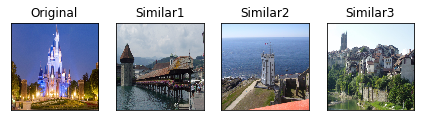

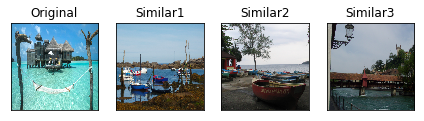

In [56]:
show_results(sim)